## Finding $\partial \sigma/\partial n_B$
1. Goal is to find this
$$
    \frac{\partial\sigma}{\partial n_B}
$$
    - Numerically
    - From our analytic expression
    
To try and see if we get the proper expression for this or not. 

In [18]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import time 

hc = 197.33 # MeV fm 
n0 = 0.153 # fm-3
pi = np.pi 

## Creating Data

In [3]:
from solver_helper import *
from broyden import * 

In [4]:
rmf = eos(g_sigma_N = 8.784820, g_omega_N = 8.720086, g_rho_N = 8.544795, b = 0.008628, c = -0.002433,\
         g_sigma_H = 5.408849, g_omega_H = 5.813391, g_rho_H = 0.0, g_phi_H = -4.110688)

# NPE 
baryon_list = [Neutron, Proton, Lambda]
meson_list = [sigma, omega, rho, phi]
lepton_list = [electron]

init(rmf, baryon_list, meson_list)

In [5]:
data = full_solve(rmf, baryon_list, lepton_list, meson_list, [7.94, 4.51, -2.24, 0.0, 210.426, 43.23, 43.23])

In [6]:
data

,nB/n0,sigma field (MeV),rho field (MeV),omega field (MeV),phi field (MeV),Neutron kF (MeV),Proton kF (MeV),electron kF (MeV),Lambda kF (MeV),Neutron frac,Proton frac,electron frac,Lambda frac
0,0.27,7.941193,-2.247962,4.514730,1.326330e-29,210.426938,43.238314,43.238314,0.000000,0.991399,0.008601,0.008601,0.000000
1,0.28,8.199099,-2.329050,4.681942,-1.235150e-27,212.960614,44.528049,44.528049,0.000000,0.990942,0.009058,0.009058,0.000000
2,0.29,8.455030,-2.409949,4.849154,-4.714163e-28,215.432600,45.809033,45.809033,0.000000,0.990477,0.009523,0.009523,0.000000
3,0.30,8.709030,-2.490655,5.016367,-4.098196e-28,217.846350,47.081534,47.081534,0.000000,0.990006,0.009994,0.009994,0.000000
4,0.31,8.961139,-2.571167,5.183579,-4.761129e-28,220.205018,48.345801,48.345801,0.000000,0.989528,0.010472,0.010472,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,7.95,76.124730,-19.385460,110.510224,-1.868708e+01,476.475033,305.525448,305.525448,519.297361,0.390896,0.103058,0.103058,0.506045
769,7.96,76.162250,-19.387725,110.628798,-1.872762e+01,476.514410,305.587973,305.587973,519.672556,0.390502,0.102992,0.102992,0.506506
770,7.97,76.199722,-19.389983,110.747356,-1.876816e+01,476.553688,305.650353,305.650353,520.047330,0.390108,0.102926,0.102926,0.506966
771,7.98,76.237145,-19.392234,110.865899,-1.880872e+01,476.592865,305.712589,305.712589,520.421683,0.389716,0.102860,0.102860,0.507425


In [7]:
nb_array = data.loc[:,'nB/n0'].values
sigma_array = data.loc[:,'sigma field (MeV)'].values
rho_array = data.loc[:,'rho field (MeV)'].values
omega_array = data.loc[:,'omega field (MeV)'].values
phi_array = data.loc[:, 'phi field (MeV)'].values 

neutron_frac = data.loc[:, 'Neutron frac'].values
proton_frac = data.loc[:, 'Proton frac'].values
electron_frac = data.loc[:, 'electron frac'].values
lambda_frac = data.loc[:, 'Lambda frac'].values

fermi_n = data.loc[:, 'Neutron kF (MeV)'].values
fermi_p = data.loc[:, 'Proton kF (MeV)'].values
fermi_e = data.loc[:, 'electron kF (MeV)'].values
fermi_l = data.loc[:, 'Lambda kF (MeV)'].values 

## Analytical Expression

In [8]:
def kf(nb, frac):
    return (3 * pi**2 * nb * frac)**(1/3)

def mass_eff(Baryon, sigma_field):
    return Baryon.num_mass - Baryon.num_g_sigma * sigma_field 

def ef(nb, frac, sigma_field, Baryon):
    return np.sqrt(kf(nb, frac)**2 + mass_eff(Baryon, sigma_field)**2)

def log_factor(nb, frac, sigma_field, Baryon):
    numerator = kf(nb, frac) + ef(nb, frac, sigma_field, Baryon) 
    denominator = mass_eff(Baryon, sigma_field) 
    
    return np.log(np.sqrt(numerator**2/denominator**2))

def dd_U_dd_sigma(sigma_field):
    term1 = 2 * sigma.num_b * Neutron.num_mass * Neutron.num_g_sigma**3 * sigma_field
    term2 = 3 * sigma.num_c * Neutron.num_g_sigma**4 * sigma_field**2 
    return term1 + term2 

In [9]:
def baryon_chem_pot(nb, frac, sigma_field, omega_field, rho_field, Baryon):
    EF = ef(nb, frac, sigma_field, Baryon)
    g_omega = Baryon.num_g_omega
    g_rho = Baryon.num_g_rho 
    
    return EF + g_omega * omega_field + g_rho * Baryon.isospin * rho_field 

In [10]:
def U(sigma_field):
    term1 = 1/3 * sigma.num_b * Neutron.num_mass * (Neutron.num_g_sigma * sigma_field)**3
    term2 = 1/4 * sigma.num_c * (Neutron.num_g_sigma * sigma_field)**4
    return -(term1 + term2)

In [117]:
def meson_contribution(sigma_field, omega_field, rho_field, phi_field):
    term1 = -sigma.num_mass**2 * sigma_field**2 
    term2 = omega.num_mass**2 * omega_field**2 
    term3 = rho.num_mass**2 * rho_field**2 
    term4 = phi.num_mass**2 * phi_field**2
    return 1/2*(term1 + term2 + term3 + term4) 

In [12]:
def baryon_contribution(nb, frac, sigma_field, Baryon):
    fermi = kf(nb, frac) 
    EF = ef(nb, frac, sigma_field, Baryon) 
    log_fac = log_factor(nb, frac, sigma_field, Baryon) 
    m = mass_eff(Baryon, sigma_field) 
    g_sigma = Baryon.num_g_sigma
    
    term1 = fermi**3 * EF 
    term2 = -3/2 * m**2 * fermi * EF 
    term3 = 3/2 * m**4 * log_fac 
    
    return 1/(12*pi**2) * (term1 + term2 + term3) 

In [13]:
def lepton_contribution(nb, frac, Lepton):
    fermi = kf(nb, frac)
    m = Lepton.num_mass
    EF = np.sqrt(fermi**2 + m**2)
    log_fac = np.log((fermi + EF)/m)
    
    term1 = fermi**3 * EF
    term2 = -3/2 * m**2 * fermi * EF
    term3 = 3/2 * m**4 * log_fac 
    
    return 1/(12 * pi**2) * (term1 + term2 + term3) 

In [123]:
baryon_pressure = np.zeros(len(nb_array))
for i in range(len(baryon_pressure)):
    Proton.num_frac = proton_frac[i]
    Neutron.num_frac = neutron_frac[i]
    Lambda.num_frac = lambda_frac[i]
    
    if (Lambda.num_frac == 0.0):
        baryon_pressure[i] = baryon_contribution(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], Proton)\
                        + baryon_contribution(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], Neutron)
    elif (Lambda.num_frac != 0.0):
        baryon_pressure[i] = baryon_contribution(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], Proton)\
                        + baryon_contribution(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], Neutron)\
                        + baryon_contribution(nb_array[i]*n0*hc**3, Lambda.num_frac, sigma_array[i], Lambda)

In [119]:
U_pressure = np.zeros(len(nb_array))
meson_pressure = np.zeros(len(nb_array))
lepton_pressure = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    electron.num_frac = electron_frac[i]
    U_pressure[i] = U(sigma_array[i])
    meson_pressure[i] = meson_contribution(sigma_array[i], omega_array[i], rho_array[i], phi_array[i])
    lepton_pressure[i] = lepton_contribution(nb_array[i]*n0*hc**3, electron_frac[i], electron)

In [124]:
tot_pressure = U_pressure + meson_pressure + baryon_pressure + lepton_pressure

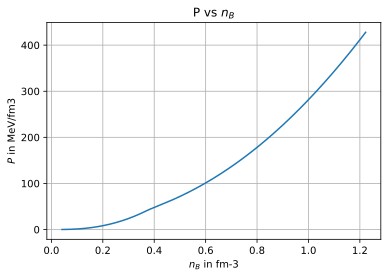

In [125]:
plt.plot(nb_array*n0, tot_pressure/hc**3)
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$P$ in MeV/fm$3$') 
plt.title('P vs $n_B$')
plt.grid()
plt.show()

### Comparing to their data

In [111]:
data2 = pd.read_csv(r'/Users/vinhtran/Downloads/datafile_gm3.txt', sep=" ", header=0,\
                       names = ['nb/n0', 'P', 'E', 'Sigma', 'Rho','Omega', 'Phi', 'xn', 'xp',\
                            'xe', 'xL', 'fermi_n', 'fermi_p', 'fermi_e', 'fermi_L', 'nan'])
data2

,nb/n0,P,E,Sigma,Rho,Omega,Phi,xn,xp,xe,xL,fermi_n,fermi_p,fermi_e,fermi_L,nan
0,0.28,0.070686,40.349774,8.198005,-2.328705,4.681230,-0.000000,0.990944,0.009056,0.009056,0.000000,212.949950,44.522679,44.522679,0.000000,NaN
1,0.29,0.080052,41.793525,8.453906,-2.409592,4.848417,-0.000000,0.990479,0.009521,0.009521,0.000000,215.421820,45.803502,45.803502,0.000000,NaN
2,0.30,0.090248,43.237612,8.707875,-2.490287,5.015604,-0.000000,0.990008,0.009992,0.009992,0.000000,217.835457,47.075844,47.075844,0.000000,NaN
3,0.31,0.101300,44.682054,8.959955,-2.570788,5.182791,-0.000000,0.989530,0.010470,0.010470,0.000000,220.194014,48.339953,48.339953,0.000000,NaN
4,0.32,0.113235,46.126866,9.210186,-2.651092,5.349977,-0.000000,0.989046,0.010954,0.010954,0.000000,222.500376,49.596057,49.596057,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,7.96,424.462572,1518.141189,76.157712,-19.387450,110.614440,-18.722709,0.390550,0.103000,0.103000,0.506450,476.509635,305.580406,305.580406,519.627154,NaN
769,7.97,425.578051,1520.582346,76.195184,-19.389709,110.732982,-18.763248,0.390156,0.102934,0.102934,0.506910,476.548918,305.642795,305.642795,520.001921,NaN
770,7.98,426.695085,1523.024904,76.232608,-19.391960,110.851508,-18.803800,0.389763,0.102868,0.102868,0.507369,476.588102,305.705038,305.705038,520.376269,NaN
771,7.99,427.813675,1525.468863,76.269983,-19.394204,110.970019,-18.844365,0.389371,0.102802,0.102802,0.507827,476.627187,305.767137,305.767137,520.750198,NaN


In [112]:
P_array = data2.loc[:,'P'].values
E_array = data2.loc[:,'E'].values

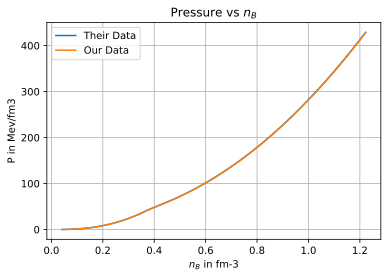

In [126]:
plt.plot(nb_array*n0, P_array, label = 'Their Data')
plt.plot(nb_array*n0, tot_pressure/hc**3, label = 'Our Data')
plt.title('Pressure vs $n_B$')
plt.grid()
plt.ylabel('P in Mev/fm3')
plt.xlabel('$n_B$ in fm-3')
plt.legend()
plt.show()

### Pressure expressions match well
1. This indicates that we have the correct analytic expression for the Pressure

### Seeing which component contributes the most...

### Equilibrium Sound Speed
$$
    c_e^2 = \frac{1}{\mu_n}\frac{dP}{dn_B}
$$

In [22]:
neutron_chem_pot = np.zeros(len(nb_array))
for i in range(len(nb_array)):
    neutron_chem_pot[i] = baryon_chem_pot(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], omega_array[i], rho_array[i], Neutron)

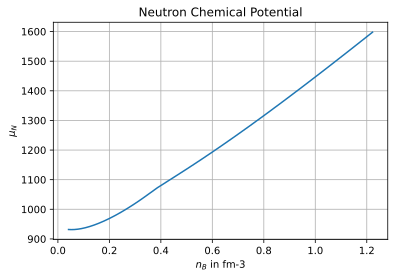

In [28]:
plt.plot(nb_array*n0, neutron_chem_pot)
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$\mu_N$')
plt.title('Neutron Chemical Potential')
plt.grid()
plt.show()

In [69]:
def total_derivative(func_data, ind_var_array):
    h = ind_var_array[2] - ind_var_array[1]
    
    total_deriv_array = np.zeros(len(func_data))
    
    for i in range(2, len(func_data)-2):
        total_deriv_array[i] = 1/(12*h)*(func_data[i-2] - 8*func_data[i -1] + 8*func_data[i + 1] - func_data[i + 2])
    
    total_deriv_array[0] = 1/(2*h)*(-3*func_data[0] +4*func_data[1] - func_data[2])
    total_deriv_array[1] = 1/(2*h)*(-3*func_data[1] +4*func_data[2] - func_data[3])
    total_deriv_array[len(func_data)-1] = 1/(2*h)*(func_data[len(func_data)-3] - 4*func_data[len(func_data)-2] + 3*func_data[len(func_data)-1])
    total_deriv_array[len(func_data)-2] = 1/(2*h)*(func_data[len(func_data)-4] - 4*func_data[len(func_data)-3] + 3*func_data[len(func_data)-2])
    
    return total_deriv_array

In [130]:
ce2 = total_derivative(tot_pressure/hc**3, nb_array*n0)/neutron_chem_pot

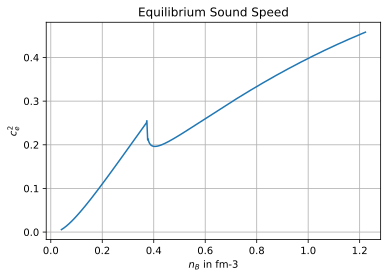

In [131]:
plt.plot(nb_array*n0, ce2)
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$c_e^2$')
plt.title('Equilibrium Sound Speed')
plt.grid()
plt.show()

### Partial Derivative of sig 

In [33]:
def alpha(nb, frac, sigma_field, Baryon):
    # writing down relevant values here so only have to calculate once
    # also for clarity below 
    fermi = kf(nb, frac) 
    EF = ef(nb, frac, sigma_field, Baryon) 
    log_fac = log_factor(nb, frac, sigma_field, Baryon) 
    m = mass_eff(Baryon, sigma_field) 
    g_sigma = Baryon.num_g_sigma 
    
    
    term1_a = fermi * EF 
    term1_b = m**2 * log_fac 
    term1 = - g_sigma/(2*pi**2) *(term1_a - term1_b) 
    
    term2_a = - g_sigma * m * fermi / EF 
    term2_b = 2 * m * g_sigma * log_fac 
    
    term2_c_1 = g_sigma / m 
    term2_c_2 = -g_sigma * m / EF / (fermi + EF) 
    term2_c = -m**2*(term2_c_1 + term2_c_2)
    
    term2 = m**2/(2*pi**2)*(term2_a + term2_b + term2_c) 
    
    return term1 + term2 

In [34]:
def beta(nb, frac, sigma_field, Baryon):
    fermi = kf(nb, frac) 
    EF = ef(nb, frac, sigma_field, Baryon) 
    log_fac = log_factor(nb, frac, sigma_field, Baryon) 
    m = mass_eff(Baryon, sigma_field)
    g_sigma = Baryon.num_g_sigma 
    
    term1 = pi**2 * frac * EF / fermi**2 
    term2 = pi**2 * frac / EF
    term3 = -m**2 * pi**2 * frac / fermi**2 / EF
    
    return m/(2*pi**2) *(term1 + term2 + term3)

In [40]:
def part_sigma_part_nb(nb, sigma_field, Baryon_list):
    numerator = 0.0
    denominator = sigma.num_mass**2 + dd_U_dd_sigma(sigma_field)
    
    for baryon in Baryon_list:
        if (baryon.num_frac != 0):
            numerator += baryon.num_g_sigma * beta(nb, baryon.num_frac, sigma_field, baryon)
            denominator += baryon.num_g_sigma * alpha(nb, baryon.num_frac, sigma_field, baryon) 
        
    return numerator / denominator 

In [41]:
part_sig_part_nb_array = np.zeros(len(nb_array), dtype = 'float') 
second_deriv_U_array = np.zeros(len(nb_array), dtype = 'float') 
alpha_array = np.zeros(len(nb_array), dtype = 'float') 
beta_array = np.zeros(len(nb_array), dtype = 'float') 

for i in range(len(nb_array)):
    # update fraction values for proton and neutron 
    Proton.num_frac = proton_frac[i]
    Neutron.num_frac = neutron_frac[i]
    Lambda.num_frac = lambda_frac[i]
    
    #second_deriv_U_array[i] = dd_U_dd_sigma(sigma_array[i])
    #alpha_array[i] = Neutron.num_g_sigma *(alpha(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], Proton)\
    #                    + alpha(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], Neutron))
    #beta_array[i] = Neutron.num_g_sigma*(beta(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], Proton)\
    #                                   + beta(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], Neutron))
    part_sig_part_nb_array[i] = part_sigma_part_nb(nb_array[i]*n0*hc**3, sigma_array[i], baryon_list)

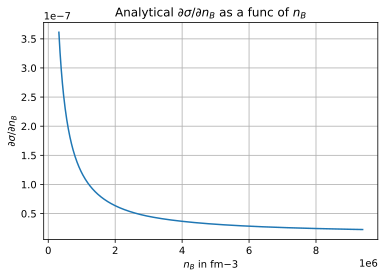

In [43]:
plt.plot(nb_array*n0*hc**3, part_sig_part_nb_array)
#plt.plot(nb_array*n0*hc**3, sigma_array)
plt.title('Analytical $\partial \sigma/\partial n_B$ as a func of $n_B$')
plt.xlabel('$n_B$ in fm$-3$')
plt.ylabel('$\partial \sigma/\partial n_B$')
plt.grid()
plt.show()

### Baryon Contribution
Code in the derivatives directly rather than the entire expression... less of a chance to mess up

In [44]:
def d_kf(nb, frac):
    return pi**2 * frac / kf(nb, frac)**2

def d_m_eff(Baryon, d_sigma):
    return - Baryon.num_g_sigma * d_sigma 

def d_e_eff(nb, frac, sigma_field, d_sigma, Baryon):
    term1 = pi**2 * frac / kf(nb, frac) 
    term2 = - mass_eff(Baryon, sigma_field) * Baryon.num_g_sigma * d_sigma
    numerator = term1 + term2 
    return numerator / ef(nb, frac, sigma_field, Baryon)

def d_log_factor(nb, frac, sigma_field, d_sigma, Baryon):
    fermi = kf(nb, frac)
    EF = ef(nb, frac, sigma_field, Baryon)
    m = mass_eff(Baryon, sigma_field)
    
    term1 = pi**2 * frac / fermi**2 / EF 
    
    term2_a = 1/m
    term2_b = - m/EF/(fermi + EF)
    term2 = Baryon.num_g_sigma * d_sigma *(term2_a + term2_b)
    
    return term1 + term2

In [45]:
def baryon_contribution_pressure(nb, frac, sigma_field, d_sigma, Baryon):
    fermi = kf(nb, frac)
    EF = ef(nb, frac, sigma_field, Baryon)
    m = mass_eff(Baryon, sigma_field) 
    log_fac = log_factor(nb, frac, sigma_field, Baryon) 
    
    d_fermi = d_kf(nb, frac) 
    d_EF = d_e_eff(nb, frac, sigma_field, d_sigma, Baryon) 
    d_m = d_m_eff(Baryon, d_sigma)
    d_log_fac = d_log_factor(nb, frac, sigma_field, d_sigma, Baryon)
    
    term1 = 3* fermi**2 * EF * d_fermi + fermi**3 * d_EF 
    
    term2_a = 2*m*d_m * fermi * EF
    term2_b = m**2 * d_fermi * EF
    term2_c = m**2 * fermi * d_EF 
    term2 = -3/2*(term2_a + term2_b + term2_c)
    
    term3_a = 4*m**3 * d_m * log_fac 
    term3_b = m**4 * d_log_fac
    term3 = 3/2 * (term3_a + term3_b)
    
    return 1/(12*pi**2)*(term1 + term2 + term3)

In [173]:
baryon_pressure_contribution_4 = np.zeros(len(nb_array))

for i in range(len(nb_array)):
    Proton.num_frac = proton_frac[i]
    Neutron.num_frac = neutron_frac[i]
    Lambda.num_frac = lambda_frac[i]
    # part_sig_nb_array_num
    #if (Lambda.num_frac == 0.0):
    #    baryon_pressure_contribution_4[i] = baryon_contribution_pressure(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], part_sig_part_nb_array[i], Neutron)\
    #                                    + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], part_sig_part_nb_array[i], Proton)
    #elif (Lambda.num_frac != 0.0):
    #    baryon_pressure_contribution_4[i] = baryon_contribution_pressure(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], part_sig_part_nb_array[i], Neutron)\
    #                                    + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], part_sig_part_nb_array[i], Proton)\
    #                                    + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Lambda.num_frac, sigma_array[i], part_sig_part_nb_array[i], Lambda)
    
    
    if (Lambda.num_frac == 0.0):
        baryon_pressure_contribution_4[i] = baryon_contribution_pressure(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], part_sig_nb_array_num[i], Neutron)\
                                        + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], part_sig_nb_array_num[i], Proton)
    elif (Lambda.num_frac != 0.0):
        baryon_pressure_contribution_4[i] = baryon_contribution_pressure(nb_array[i]*n0*hc**3, Neutron.num_frac, sigma_array[i], part_sig_nb_array_num[i], Neutron)\
                                        + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Proton.num_frac, sigma_array[i], part_sig_nb_array_num[i], Proton)\
                                        + baryon_contribution_pressure(nb_array[i]*n0*hc**3, Lambda.num_frac, sigma_array[i], part_sig_nb_array_num[i], Lambda)

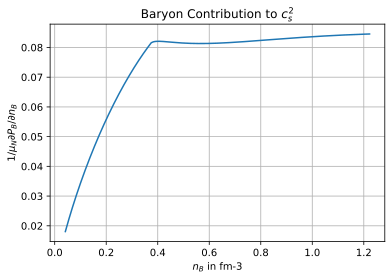

In [174]:
plt.plot(nb_array*n0, baryon_pressure_contribution_4/neutron_chem_pot)
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$1/\mu_N \partial P_B /\partial n_B$')
plt.title('Baryon Contribution to $c_s^2$')
plt.grid()
plt.show()

### Sigma Self Interaction Contribution

In [97]:
def U_contribution_2(sigma_field, d_sigma):
    term1 = sigma.num_b * Neutron.num_mass * Neutron.num_g_sigma**3 * sigma_field**2
    term2 = sigma.num_c * Neutron.num_g_sigma**4 * sigma_field**3
    
    return -d_sigma * (term1 + term2)

In [171]:
U_pressure_2 = np.zeros(len(nb_array))
for i in range(len(U_pressure_2)): # part_sig_nb_array_num
    #U_pressure_2[i] = U_contribution_2(sigma_array[i], part_sig_part_nb_array[i])
    U_pressure_2[i] = U_contribution_2(sigma_array[i], part_sig_nb_array_num[i])

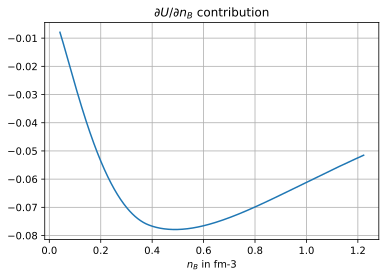

In [172]:
plt.plot(nb_array*n0, U_pressure_2/neutron_chem_pot)
plt.xlabel('$n_B$ in fm-3')
plt.title('$\partial U/\partial n_B$ contribution')
plt.grid()
plt.show()

### Meson Contribution

In [100]:
def meson_contribution_2(sigma_field, omega_field, rho_field, phi_field, d_sigma, Baryon_list):
    
    sigma_contribution = -sigma.num_mass**2 * sigma_field * d_sigma 
    
    omega_contribution = 0.0 
    rho_contribution = 0.0 
    phi_contribution = 0.0
    for baryon in baryon_list:
        omega_contribution += baryon.num_g_omega * baryon.num_frac * omega_field
        rho_contribution += baryon.num_g_rho * baryon.num_frac * baryon.isospin* rho_field
        phi_contribution += baryon.num_g_phi * baryon.num_frac * phi_field 

    return sigma_contribution + omega_contribution + rho_contribution + phi_contribution

In [169]:
meson_pressure_2 = np.zeros(len(nb_array))

for i in range(len(meson_pressure_2)):
    Proton.num_frac = proton_frac[i]
    Neutron.num_frac = neutron_frac[i]
    Lambda.num_frac = lambda_frac[i]
    # part_sig_nb_array_num
   # meson_pressure_2[i] = meson_contribution_2(sigma_array[i], omega_array[i], rho_array[i], phi_array[i], part_sig_part_nb_array[i], baryon_list)
    meson_pressure_2[i] = meson_contribution_2(sigma_array[i], omega_array[i], rho_array[i], phi_array[i], part_sig_nb_array_num[i], baryon_list)

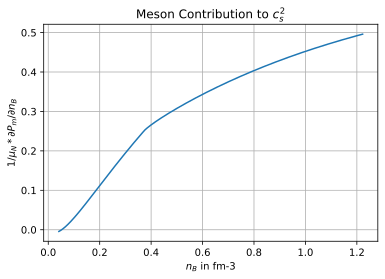

In [170]:
plt.plot(nb_array*n0, meson_pressure_2/neutron_chem_pot)
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$1/\mu_N *  \partial P_m/\partial n_B$')
plt.title('Meson Contribution to $c_s^2$')
plt.grid()
plt.show()

### Lepton Contribution

In [103]:
def lepton_contribution_2(nb, frac, Lepton):
    fermi = kf(nb, frac) 
    m = Lepton.num_mass
    EF = np.sqrt(fermi**2 + m**2) 
    
    term1 = 3 * EF**2 * fermi**2 
    term2 = fermi**4 
    term3 = -3/2 * m**2 * (EF**2 + fermi**2) 
    term4 = 3/2 * m**4 
    
    return 1/12 * frac / fermi**2 /EF *(term1 + term2 + term3 + term4)

In [104]:
lepton_pressure_2 = np.zeros(len(nb_array))

for i in range(len(lepton_pressure_2)):
    electron.num_frac = electron_frac[i]
    
    lepton_pressure_2[i] = lepton_contribution_2(nb_array[i]*n0*hc**3, electron.num_frac, electron)

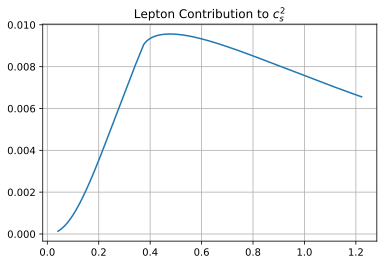

In [105]:
plt.plot(nb_array*n0, lepton_pressure_2/neutron_chem_pot)
#plt.xlabel('$n_B$')
#plt.ylabel('$1/\mu_N *  \partial P_m/\partial n_B$')
plt.title('Lepton Contribution to $c_s^2$')
plt.grid()
plt.show()

In [175]:
cs2 = 1/neutron_chem_pot*(baryon_pressure_contribution_4 + lepton_pressure_2 + meson_pressure_2 + U_pressure_2)

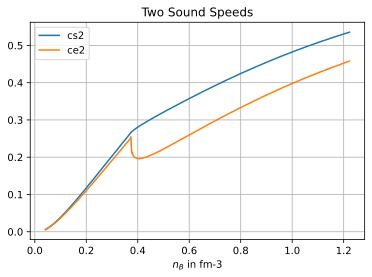

In [176]:
plt.plot(nb_array*n0, cs2, label = 'cs2')
plt.plot(nb_array*n0, ce2, label = 'ce2')
plt.title('Two Sound Speeds')
plt.xlabel('$n_B$ in fm-3')
#plt.ylabel('$c_s^2$')
plt.legend()
plt.grid()
plt.show()

### Sound Speed Difference

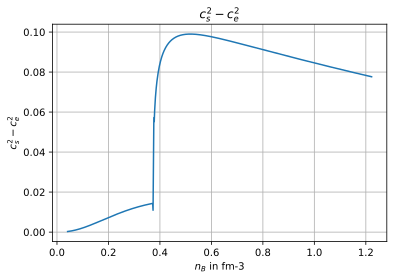

In [177]:
plt.plot(nb_array*n0, cs2-ce2)
plt.title('$c_s^2 - c_e^2$')
plt.xlabel('$n_B$ in fm-3')
plt.ylabel('$c_s^2 - c_e^2$')
plt.grid()
plt.show()

## Numerical Approach
We can numerically calculate this partial derivative. 
1. 
$$
    \frac{\partial \sigma}{\partial n_B}\bigg|_{x_n}
$$
Idea: we have three variables that we have solved for consistently subject to the two constraints above. Then each collection of $(\sigma_i, {n_B}_i, {x_n}_i)$ represent a point in some sort of "phase space". To calculate the partial derivative of one variable like $\sigma$ wrt to another variable like $n_B$ at a point $i$ in this phase space, we want to re-solve our system of equations while perturbing the independent variable while holding the others fixed. That is,  we can solve our system of equations again to find 
$$
    \sigma(n_B + h, x_n),\; \sigma(n_B, x_n),\;\sigma(n_B - h, x_n) 
$$
and which would let us find
$$
    \frac{\partial \sigma}{\partial n_B}\bigg|_{x_n}
    \approx 
    \frac{1}{2h}\left[-3\sigma(n_B, x_n) + 4\sigma(n_B + h, x_n) - \sigma(n_B + 2h,x_n) \right] 
$$
via a 3-point formula. 
    - One thing to note: we do not fix the value for the other variable for the entire range. We update it as we iterate through all the phase space points but at each step we calculate the derivative while holding it fixed. We'll see if we have to keep it fixed for the entire range. 
    - We are trying this at the moment for the sigma field partial derivative but this approach could be applied to the chemical potentials directly. 

In [76]:
def kf(nb, frac):
    return (3 * np.pi**2 * nb * frac)**(1/3)

def mass_eff(baryon, sigma_field):
    return baryon.num_mass - baryon.num_g_sigma * sigma_field 

def e_eff(nb, frac, sigma_field, baryon):
    return np.sqrt(kf(nb, frac)**2 + mass_eff(baryon, sigma_field)**2)

def log_factor(nb, frac, sigma_field, baryon):
    numerator = kf(nb, frac) + e_eff(nb, frac, sigma_field, baryon)
    denominator = mass_eff(baryon, sigma_field)
    return np.log(np.sqrt(numerator**2/denominator**2))

In [165]:
def sigma_EOM(sigma_field, nb, proton_frac, neutron_frac, lambda_frac = 0.0):
    term1 = sigma.num_mass**2 * sigma_field 
    term2 = dU(sigma_field) 
    
    term3 = Proton.num_g_sigma * scalar_density(nb, proton_frac, sigma_field, Proton) 
    term3 += Neutron.num_g_sigma * scalar_density(nb, neutron_frac, sigma_field, Neutron)
    term3 += Lambda.num_g_sigma * scalar_density(nb, lambda_frac, sigma_field, Lambda)
    
    return term1 + term2 - term3 

In [164]:
def scalar_density(nb, frac, sigma_field, baryon):
    fermi = kf(nb, frac)
    EF = e_eff(nb, frac, sigma_field, baryon) 
    m = mass_eff(baryon, sigma_field)
    log_fac = log_factor(nb, frac, sigma_field, baryon)
    
    term1 = fermi * EF
    term2 = m**2 * log_fac
    
    return (m/2/np.pi**2)*(term1 - term2)

def dU(sigma_field):
    term1 = sigma.num_b * Neutron.num_mass * Neutron.num_g_sigma**3 * sigma_field**2
    term2 = sigma.num_c * Neutron.num_g_sigma**4 * sigma_field**3
    return term1 + term2

In [166]:
def partial_derivative(function, sigma_array, NB_array, XP_array, XN_array, XL_array, h, var):
    # first solve 
    part_deriv_array = np.zeros(len(nb_array))
    
    #sig1 = optimize.fsolve(function, 0.0, args = (nb - h, xn))[0]
    #sig2 = optimize.fsolve(function, 0.0, args = (nb, xn))[0]
    #sig3 = optimize.fsolve(function, 0.0, args = (nb + h, xn))[0]
    
    # calculate 3 point derivative 
    if (var == 'nb' ):
        for i in range(len(part_deriv_array)):
            sig1 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i]*n0*hc**3, XP_array[i], XN_array[i], XL_array[i]))[0]
            sig2 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i]*n0*hc**3 + h, XP_array[i], XN_array[i], XL_array[i]))[0]
            sig3 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i]*n0*hc**3 + 2*h, XP_array[i], XN_array[i], XL_array[i]))[0]
        
            part_deriv_array[i] = 1/(2*h)*(-3*sig1 + 4*sig2 - sig3)
    
        return part_deriv_array
    
    elif (var == 'xp'):
        for i in range(len(part_deriv_array)):
            sig1 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i], XP_array[i], XN_array[i]))[0]
            sig2 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i], XP_array[i] + h, XN_array[i]))[0]
            sig3 = optimize.fsolve(function, sigma_array[i], args = (NB_array[i], XP_array[i] + 2*h, XN_array[i]))[0]
        
            part_deriv_array[i] = 1/(2*h)*(-3*sig1 + 4*sig2 - sig3)
        
        return part_deriv_array 

In [167]:
part_sig_nb_array_num = partial_derivative(sigma_EOM, sigma_array, nb_array, proton_frac, neutron_frac, lambda_frac, 0.01, 'nb')

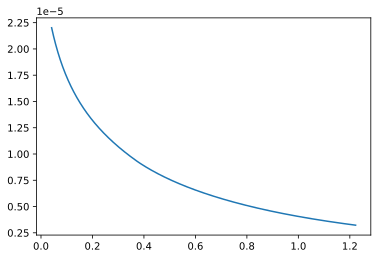

In [168]:
plt.plot(nb_array*n0, part_sig_nb_array_num)